In [130]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from numpy import array

In [131]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)

In [132]:
n_timestamp = 10
train_days = 164925  
testing_days = 100000 
n_epochs = 25
filter_on = 1
model_type = 2
url = "openweatherdata.csv"
dataset = pd.read_csv(url)
target = 'weather_main'
if filter_on == 1:
    dataset['temp'] = medfilt(dataset['temp'], 3)
    dataset['temp'] = gaussian_filter1d(dataset['temp'], 1.2)
    

In [133]:
train_set = dataset[0:train_days].reset_index(drop=True)
test_set = dataset[train_days: train_days+testing_days].reset_index(drop=True)
training_set = train_set.iloc[:, 6:7].values
testing_set = test_set.iloc[:, 6:7].values

In [134]:
categorical_features = [column_name for column_name in dataset.columns if dataset[column_name].dtype == 'O']
print("Number of Categorical Features: {}".format(len(categorical_features)))
print("Categorical Features: ",categorical_features)

Number of Categorical Features: 5
Categorical Features:  ['dt_iso', 'city_name', 'weather_main', 'weather_description', 'weather_icon']


In [135]:
numerical_features = [column_name for column_name in dataset.columns if dataset[column_name].dtype != 'O']
print("Number of Numerical Features: {}".format(len(numerical_features)))
print("Numerical Features: ",numerical_features)

Number of Numerical Features: 27
Numerical Features:  ['dt', 'timezone', 'lat', 'lon', 'temp', 'temp_min', 'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'rain_6h', 'rain_12h', 'rain_24h', 'rain_today', 'snow_1h', 'snow_3h', 'snow_6h', 'snow_12h', 'snow_24h', 'snow_today', 'clouds_all', 'weather_id']


In [136]:
for each_feature in categorical_features:
    print("Cardinality(no. of unique values) of {} are: {}".format(each_feature,len(dataset[each_feature].unique())))

Cardinality(no. of unique values) of dt_iso are: 263136
Cardinality(no. of unique values) of city_name are: 1
Cardinality(no. of unique values) of weather_main are: 13
Cardinality(no. of unique values) of weather_description are: 31
Cardinality(no. of unique values) of weather_icon are: 16


In [137]:
categorical_features = [column_name for column_name in dataset.columns if dataset[column_name].dtype == 'O']
print("Number of Categorical Features: {}".format(len(categorical_features)))
print("Categorical Features: ",categorical_features)

Number of Categorical Features: 5
Categorical Features:  ['dt_iso', 'city_name', 'weather_main', 'weather_description', 'weather_icon']


<AxesSubplot:>

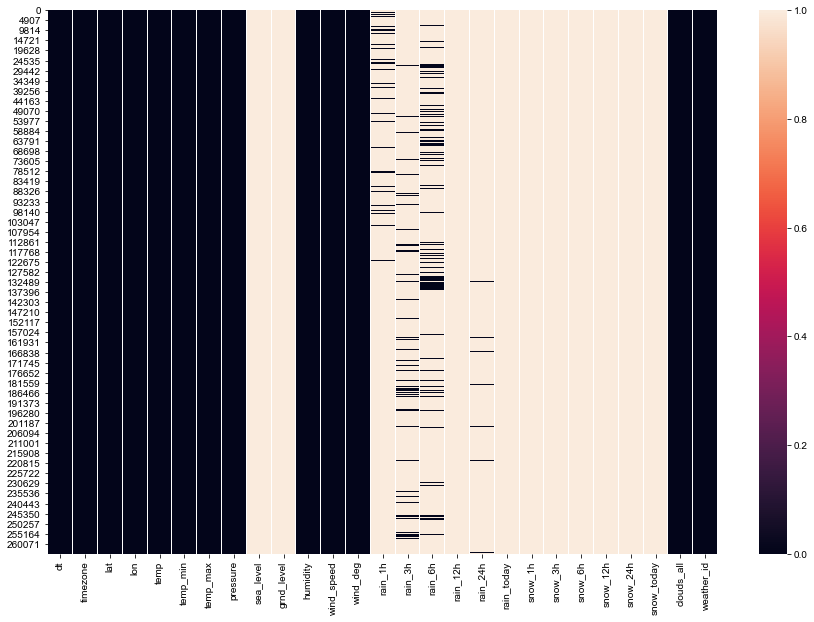

In [138]:
plt.figure(figsize=(15,10))
sns.heatmap(dataset[numerical_features].isnull(),linecolor='white')

<AxesSubplot:>

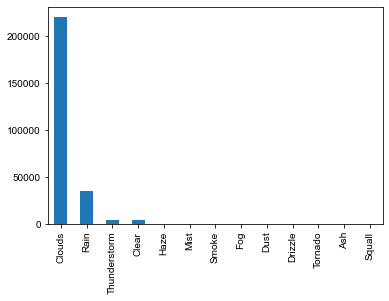

In [139]:
dataset['weather_main'].value_counts().plot(kind='bar')

In [140]:
sc = MinMaxScaler(feature_range = (0, 1)) 
training_set_scaled = sc.fit_transform(training_set) 
testing_set_scaled = sc.fit_transform(testing_set)

In [141]:
print(len(training_set_scaled))

164925


In [142]:
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        if end_ix > len(sequence)-1:
            break
        # i to end_ix as input
        # end_ix as target output
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
if model_type == 1:
    # Single cell LSTM
    model = Sequential()
    model.add(LSTM(units = 50, activation='relu',input_shape = (X_train.shape[1], 1)))
    model.add(Dense(units = 1))
if model_type == 2:
    # Stacked LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
if model_type == 3:
    # Bidirectional LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))





#
# Start training
#
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = 32)
loss = history.history['loss']
epochs = range(len(loss))






#
# Get predicted data
#
y_predicted = model.predict(X_test)

#
# 'De-normalize' the data
#
y_predicted_descaled = sc.inverse_transform(y_predicted)
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()







#
# Show results
#
plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset['temp'], color = 'black', linewidth=1, label = 'True value')
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("All data")


plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (n days)")

plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[0:10000], color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled[0:10000], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (first 10000 days)")

plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='black')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test_descaled-y_predicted_descaled, color='black')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()



mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))

Epoch 1/25
5154/5154 [==============================] - 60s 11ms/step - loss: 0.0037
Epoch 2/25
5154/5154 [==============================] - 64s 12ms/step - loss: 7.3187e-05
Epoch 3/25
5154/5154 [==============================] - 75s 15ms/step - loss: 4.2637e-05
Epoch 4/25
5154/5154 [==============================] - 77s 15ms/step - loss: 3.4401e-05
Epoch 5/25
5154/5154 [==============================] - 79s 15ms/step - loss: 3.0711e-05
Epoch 6/25
5154/5154 [==============================] - 72s 14ms/step - loss: 2.7513e-05
Epoch 7/25
5154/5154 [==============================] - 68s 13ms/step - loss: 2.4474e-05
Epoch 8/25
5154/5154 [==============================] - 71s 14ms/step - loss: 2.2541e-05
Epoch 9/25
5154/5154 [==============================] - 59s 12ms/step - loss: 2.1443e-05
Epoch 10/25
5154/5154 [==============================] - 81s 16ms/step - loss: 2.0510e-05
Epoch 11/25
5154/5154 [==============================] - 78s 15ms/step - loss: 2.0318e-05
Epoch 12/25
5154/5154 [

In [ ]:
import pickle
with open('Despens.pkl', 'wb') as file:
    pickle.dump(sc, file)

In [ ]:
dataset = dataset.fillna(1)

In [ ]:

print(dataset)

In [ ]:
import numpy as np
n=75
predict_list = np.array([n]).reshape(-1,1)

In [ ]:

predict_list = sc.transform(predict_list)
print(predict_list)
if predict_list == 0:
 n="rain"
 print("rain")
elif predict_list<1:
 n="clouds"
 print("clouds")
else:
 n="Thunderstorm "
 print("Thunderstorm ")


In [129]:
import csv 
fields = ['Weather_main']  
rows = [[n]]
filename = "test.csv"
with open(filename, 'w') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    csvwriter.writerow(fields)  
    csvwriter.writerows(rows)

[[0.6764269 ]
 [0.66901636]
 [0.65314245]
 ...
 [0.5764506 ]
 [0.62648916]
 [0.66344416]]
Rain


Total number of rows in dataset: 264924

          dt                         dt_iso  timezone city_name       lat  \
0  631152000  1990-01-01 00:00:00 +0000 UTC     28800  Denpasar -8.652497   
1  631155600  1990-01-01 01:00:00 +0000 UTC     28800  Denpasar -8.652497   
2  631159200  1990-01-01 02:00:00 +0000 UTC     28800  Denpasar -8.652497   
3  631162800  1990-01-01 03:00:00 +0000 UTC     28800  Denpasar -8.652497   
4  631166400  1990-01-01 04:00:00 +0000 UTC     28800  Denpasar -8.652497   

          lon       temp  temp_min  temp_max  pressure  ...  snow_3h  snow_6h  \
0  115.219117  26.019492     25.82     25.82    1010.0  ...      NaN      NaN   
1  115.219117  26.201707     26.20     26.20    1011.0  ...      NaN      NaN   
2  115.219117  26.473175     26.45     26.45    1011.0  ...      NaN      NaN   
3  115.219117  26.752311     26.80     26.80    1011.0  ...      NaN      NaN   
4  115.219117  26.990590     27.04     27.04    1010.0  ...      NaN      NaN   

   snow_1

[[26.01949235]
 [26.20170737]
 [26.47317526]
 ...
 [25.05593171]
 [26.20075077]
 [27.14604011]]
[86 84 84 ... 83 83 83]


array([[0.61969517],
       [0.6281834 ],
       [0.64082936],
       ...,
       [0.57480903],
       [0.62813884],
       [0.67217384]])

NameError: name 'samples_to_predict' is not defined